# Introduction to Cross-Validation

## Introduction

Cross-validation is another model validation strategy, which addresses one of the limitations of the train-test split strategy.

## Objectives

You will be able to:

* Describe the process of cross-validation
* Perform cross-validation on a model
* Compare and contrast model validation strategies

## Limitations of Train-Test Split

Recall that a train-test split means shuffling the data and randomly selecting a subset to be the _test_ set. The test set is a stand-in for the genuinely unknown data that the model would encounter in the real world, and helps to give a realistic picture of model performance and to identify issues like overfitting.

The problem with this, as you may have already noticed, is that the metrics produced by a train-test split are **highly dependent on the particular split** that happened to be created. You might end up with an overly optimistic or overly pessimistic impression of model performance just because of which records ended up in the train vs. test sets.

For example, the code below creates two different splits of the Auto MPG dataset, each with the same ratio of train to test, but using different random seeds.

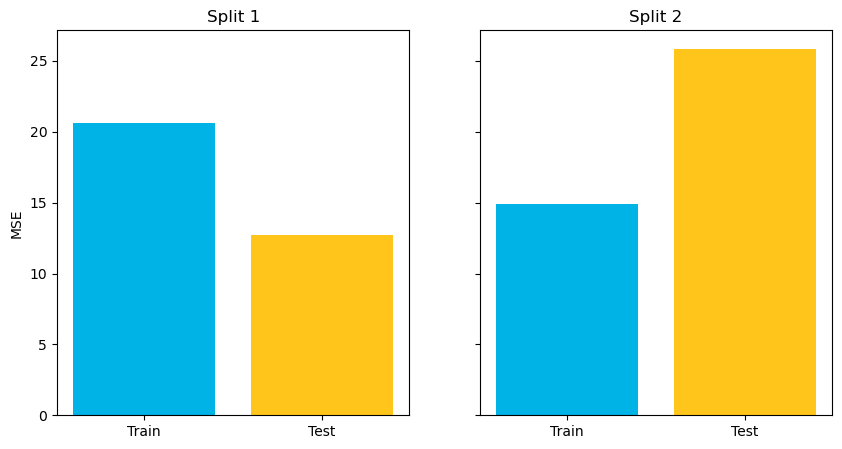

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set up data and model
data = pd.read_csv('auto-mpg.csv')
y = data['mpg']
X = data[['acceleration', 'horsepower', 'displacement', 'weight']]
linreg = LinearRegression()

# Split using random_state 87
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, random_state=87, test_size=0.33)
linreg.fit(X_train_1, y_train_1)
train_mse_1 = mean_squared_error(y_train_1, linreg.predict(X_train_1))
test_mse_1 = mean_squared_error(y_test_1, linreg.predict(X_test_1))

# Split using random_state 41
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, random_state=41, test_size=0.33)
linreg.fit(X_train_2, y_train_2)
train_mse_2 = mean_squared_error(y_train_2, linreg.predict(X_train_2))
test_mse_2 = mean_squared_error(y_test_2, linreg.predict(X_test_2))

# Plot metrics
fig, (left, right) = plt.subplots(ncols=2, figsize=(10,5), sharey=True)
labels = ["Train", "Test"]
colors = ["#00B3E6", "#FFC51B"]
left.bar(labels, [train_mse_1, test_mse_1], color=colors)
left.set_title("Split 1")
left.set_ylabel("MSE")
right.bar(labels, [train_mse_2, test_mse_2], color=colors)
right.set_title("Split 2");

Both of the models shown above are using the same `X` and `y` and the same ratio of train to test, but one seems to indicate that the train score is much better than the test score, and the other seems to indicate that the test score is much better than the train score.

Which one is the "real" result? And how do you know, if you only perform a single split, whether it's going to resemble the model on the left or the model on the right?

Unfortunately with a standard train-test split process, it's impossible to know. Essentially you are collecting a single point statistic and you might be "unlucky" in how the numbers happen to fall.

## K-Fold Cross-Validation

K-fold cross validation expands on the idea of training and test splits by splitting the entire dataset into `K` equal sections of data. We'll then iteratively train `K` linear regression models on the data, with each model using a different section of data as the test set, and all other sections combined as the training set.

We can then average the individual results from each of these linear models to get a cross-validation MSE. This will be closer to the model's "actual" MSE, since results that are higher than average will cancel out the results that are lower than average.

The diagram below gives an example of what cross-validation with `K = 10` might look like:

<img src='https://curriculum-content.s3.amazonaws.com/data-science/images/new_cross-val-graphic.png' width="800">

### Cross-Validation in Scikit-Learn

There are multiple ways to perform cross-validation with scikit-learn. You can read more extensive documentation [here](https://scikit-learn.org/stable/modules/cross_validation.html).

#### `cross_val_score`

If you are mainly just interested in the score on the validation (test) data, there is a function called `cross_val_score` ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)). This takes in the model and the data, and returns the validation score for each split:

In [2]:
from sklearn.model_selection import cross_val_score

cross_val_score(linreg, X, y)

array([ 0.4918456 ,  0.35769361,  0.74442295,  0.68913303, -0.65804595])

By default there will be 5 splits and the score returned will be the result of the `.score()` method for the model. In the case shown here it's a `LinearRegression` ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)) which means it returns the coefficient of determination ($R^2$).

If we wanted 10 splits rather than 5, we could use the `cv` argument:

In [3]:
cross_val_score(linreg, X, y, cv=10)

array([ 0.54461117,  0.49833098,  0.10383265,  0.65045556,  0.6306485 ,
        0.83816174,  0.70048053,  0.67553093, -0.66050541, -0.09016385])

And if we wanted to use MSE instead of R-Squared, we could use the `scoring` argument:

In [4]:
cross_val_score(linreg, X, y, scoring="neg_mean_squared_error")

array([-17.17351787, -22.56069047,  -8.60892235, -15.11906997,
       -59.57600269])

Why are the scores negative? Because conventionally in scikit-learn you want a larger score to be better. So for an error-based metric like MSE, the built-in scoring option uses _negative_ MSE.

If you want to use a custom metric you can use `make_scorer`. Here it is demonstrated with `mean_squared_error` (imported previously from scikit-learn) but you could also write your own function:

In [5]:
from sklearn.metrics import make_scorer

cross_val_score(linreg, X, y, scoring=make_scorer(mean_squared_error))

array([17.17351787, 22.56069047,  8.60892235, 15.11906997, 59.57600269])

#### `cross_validate`

If you want more information from the scoring process and not just the validation scores for a single metric, there is another function from scikit-learn called `cross_validate` ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)).

`cross_validate` can be used to get the same information as `cross_val_score`:

In [6]:
from sklearn.model_selection import cross_validate

cross_validate(linreg, X, y)["test_score"]

array([ 0.4918456 ,  0.35769361,  0.74442295,  0.68913303, -0.65804595])

But it also automatically provides information about timing:

In [7]:
cross_validate(linreg, X, y)

{'fit_time': array([0.01264477, 0.00445104, 0.00231695, 0.00303411, 0.00300193]),
 'score_time': array([0.00179815, 0.00211191, 0.00166392, 0.00175595, 0.00187993]),
 'test_score': array([ 0.4918456 ,  0.35769361,  0.74442295,  0.68913303, -0.65804595])}

Just like with `cross_val_score` you can use the `cv` argument to change the number of splits:

In [8]:
cross_validate(linreg, X, y, cv=10)

{'fit_time': array([0.00424528, 0.0043571 , 0.0037632 , 0.01109815, 0.00324488,
        0.00444698, 0.00643587, 0.01317978, 0.01407433, 0.0084343 ]),
 'score_time': array([0.00232887, 0.00575805, 0.00179386, 0.00183988, 0.00490189,
        0.00228596, 0.00188613, 0.00187922, 0.00266576, 0.00211096]),
 'test_score': array([ 0.54461117,  0.49833098,  0.10383265,  0.65045556,  0.6306485 ,
         0.83816174,  0.70048053,  0.67553093, -0.66050541, -0.09016385])}

If you want scores for multiple different metrics at once (e.g. R-Squared and negative MSE), that would look like this:

In [9]:
cross_validate(linreg, X, y, scoring=["r2", "neg_mean_squared_error"])

{'fit_time': array([0.01199198, 0.00225401, 0.00997305, 0.00337219, 0.00248194]),
 'score_time': array([0.00202703, 0.00225115, 0.00355315, 0.00381112, 0.0022552 ]),
 'test_r2': array([ 0.4918456 ,  0.35769361,  0.74442295,  0.68913303, -0.65804595]),
 'test_neg_mean_squared_error': array([-17.17351787, -22.56069047,  -8.60892235, -15.11906997,
        -59.57600269])}

And if you want to compare the train vs. test scores (e.g. to look for overfitting), that would look like this:

In [10]:
cross_validate(linreg, X, y, return_train_score=True)

{'fit_time': array([0.00807619, 0.00243497, 0.00259781, 0.00233912, 0.00310016]),
 'score_time': array([0.00582695, 0.00215006, 0.00543213, 0.00164294, 0.00323486]),
 'test_score': array([ 0.4918456 ,  0.35769361,  0.74442295,  0.68913303, -0.65804595]),
 'train_score': array([0.694036  , 0.7203816 , 0.69611334, 0.7014972 , 0.76292441])}

### Reporting Cross-Validation Scores

Often your stakeholders will want a single metric or visualization that represents model performance, not a list of scores like cross-validation produces.

One straightforward way to achieve this is to take the average:

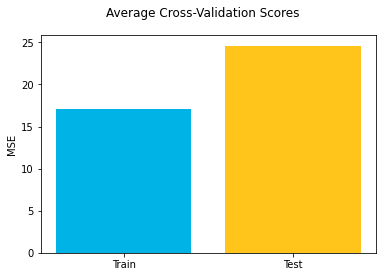

In [11]:
cross_val_results = cross_validate(linreg, X, y, scoring="neg_mean_squared_error", return_train_score=True)
# Negative signs in front to convert back to MSE from -MSE
train_avg = -cross_val_results["train_score"].mean()
test_avg = -cross_val_results["test_score"].mean()

fig, ax = plt.subplots()
ax.bar(labels, [train_avg, test_avg], color=colors)
ax.set_ylabel("MSE")
fig.suptitle("Average Cross-Validation Scores");

Another way, if you have enough folds to make it worthwhile, is to show the distribution of the train vs. test scores using a histogram or a box plot. *N.B.*: The *x*-axes are different scales, but the focus is on the different shapes of the respective distributions.

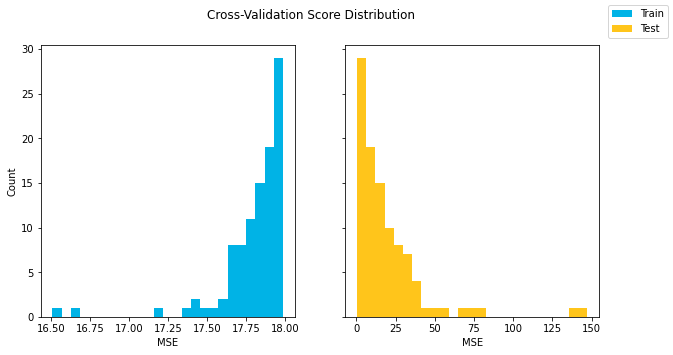

In [12]:
cross_val_results = cross_validate(linreg, X, y, cv=100, scoring="neg_mean_squared_error", return_train_score=True)
train_scores = -cross_val_results["train_score"]
test_scores = -cross_val_results["test_score"]

fig, (left, right) = plt.subplots(ncols=2, figsize=(10,5), sharey=True)
bins=25
left.hist(train_scores, label=labels[0], bins=bins, color=colors[0])
left.set_ylabel("Count")
left.set_xlabel("MSE")
right.hist(test_scores, label=labels[1], bins=bins, color=colors[1])
right.set_xlabel("MSE")
fig.suptitle("Cross-Validation Score Distribution")
fig.legend();

## Comparing and Contrasting Train-Test Split and Cross-Validation

As noted previously, cross-validation is a more sophisticated approach than train-test split because it produces multiple metric estimates rather than a single estimate. You can start to get a sense of the _variance_ in the metrics from cross-validation in a way that you can't from a train-test split. So cross-validation is generally seen as a more **reliable** validation strategy than train-test split.

On the other hand, there are some downsides to cross-validation, particularly in scikit-learn.

First, cross-validation **does not shuffle** the data before splitting it into folds. This might mean that there are some aspects of the splits that are not representative of what true training data vs. unseen data would look like. This behavior can be modified by writing custom cross-validation code that builds on top of scikit-learn classes like `KFold` ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)).

Second, cross-validation is **more computationally expensive**, because it is fitting many models rather than fitting a single model and scoring it on multiple datasets. For linear regression this tends not to be a significant issue, but for more complex models (e.g. neural networks) we conventionally don't use cross-validation because it would take so much time and computational resources.

Finally, the scikit-learn implementation of cross-validation makes it more prone to **data leakage**. Because the `cross_val_score` or `cross_validate` functions take in the whole dataset _and_ the model (vs. `train_test_split` which just splits the data), you typically have to preprocess the data all together before passing it in. This can lead to overly optimistic results compared to unseen data that must be processed separately. The solution to this is using a more-advanced modeling technique called a `Pipeline` ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)) that combines all of the preprocessing and modeling into a single estimator that can be passed in to the cross-validation function.

Note that there is also not a strict choice between a train-test split and cross-validation. You might consider combining the approaches, e.g. performing a train-test split and then using cross-validation on just the training set. There are also additional variations on these validation techniques you might want to consider, such as [repeated](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html), [grouped](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html), and [leave one out](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html) validation.

## Summary 

Well done! In this lesson you learned about the concept of cross-validation and how cross-validation can overcome the limitations of train-test split. You also saw how to use cross-validation with scikit-learn. In the next lesson, you will utilize cross-validation on the Ames Housing data. 